# CascadingClassifier

Cascading es una técnica de ensambles que consiste en entrenar modelos con las instancias predichas con poca certeza por modelos anteriores. Como **sklearn** no provee este modelo, implementamos una versión propia simplificada.

In [2]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from scoring import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import l2

import pandas as pd
import numpy as np
from joblib import dump, load
pd.set_option('display.max_rows', 10)
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementación

In [3]:
"""
Devuelve un array en el que el elemento x[i] es el elemento
mas alejado de 0.5 entre arr_a[i] y arr_b[i]
"""
def get_further(arr_a, arr_b):
    return np.array([a if abs(a - 0.5) > abs(b - 0.5) else b for a,b in zip(arr_a, arr_b)])

class CascadingClassifier:
    """
    threshold es la certeza minima que debe tener un modelo
    para clasificar correctamente una instancia. Todas las
    instancias cuya certeza sean menores que el threshold,
    se pasaran al siguiente modelo, tanto para el fit() como
    para el predict_proba()
    models es una lista de pares ('nombre', modelo)
    idx_to_use_calib es una lista con los indices de los modelos
    que deben ser calibrados (usando CalibratedClassifierCV)
    """
    def __init__(self, models, threshold, idx_to_use_calib):
        # Guardamos los modelos junto con sus calibradores
        # para que los resultados de predict_proba() sean mas
        # precisos
        # Si el usuario lo desea, puede desactivar esta opcion
        models_list = []
        for i, model_pair in enumerate(models):
            if i in idx_to_use_calib:
                models_list.append((model_pair[0], CalibratedClassifierCV(model_pair[1], n_jobs=-1)))
            else:
                models_list.append(model_pair)
        
        self.models = models_list
        self.threshold = threshold
    
    def fit(self, X_train, Y_train, verbose=True):
        return self._fit_rec(X_train, Y_train, self.models, verbose)
    
    """
    Entrena al primer modelo de models_subset
    si al predecir las mismas instancias con que
    fue entrenado la certeza es menor que el threshold
    (podemos confiar de este numero gracias a la calibracion)
    entonces se invoca recursivamente con el siguiente modelo
    pasando como parametros las instancias predichas con poca
    certeza
    """
    def _fit_rec(self, X_train_subset, Y_train_subset, models_subset, verbose):
        if len(models_subset) == 0:
            return
        model = models_subset[0][1]
        model_name = models_subset[0][0]
        
        model.fit(X_train_subset, Y_train_subset)
        model_output = model.predict_proba(X_train_subset)
        max_model_output = np.maximum(model_output[:,0], model_output[:,1])
        
        not_so_sure_points_index = np.where(max_model_output < self.threshold)[0]

        X_train_next_subset = X_train_subset[not_so_sure_points_index]
        Y_train_next_subset = Y_train_subset[not_so_sure_points_index]
        
        not_sure_len = len(not_so_sure_points_index)
        sure_len = len(model_output) - not_sure_len
        
        if verbose:
            print(f"Modelo: {model_name} logro clasificar {sure_len} instancias, {not_sure_len} no lograron ser clasificadas")
            
        self._fit_rec(X_train_next_subset, Y_train_next_subset, models_subset[1:], verbose)
        
    def predict_proba(self, X_test, verbose=True):
        # old_predict es una lista con todos los valores en 0.5
        # porque el modelo en la iteracion 0 no tiene ninguna certeza
        # sobre las predicciones, ya que no hay predicciones
        return self._predict_proba_rec(X_test, self.models, 0.5*np.ones(shape=len(X_test)), verbose)
    
    """
    Predice las instancias de test con el primer modelo de
    models_subset
    old_predict es una lista con las certezas de que cada instancia
    sea positiva (== 1)
    Se invoca recursivamente con aquellas instancias que no logro clasificar
    con certeza suficiente
    Devuelve una lista con los maximos entre old_predict y las nuevas predicciones
    (esto es para asegurar el maximo rendimiento para aquellas instancias que
    no fueron bien clasificadas incluso al agotarse los modelos de la lista)
    """
    def _predict_proba_rec(self, X_test_subset, models_subset, old_predict, verbose):
        if len(models_subset) == 0:
            return old_predict     
        model = models_subset[0][1]
        model_name = models_subset[0][0]

        model_output = model.predict_proba(X_test_subset)
        
        max_model_output = np.maximum(model_output[:,0], model_output[:,1])

        not_so_sure_points_index = np.where(max_model_output < self.threshold)[0]
        
        X_test_next_subset = X_test_subset[not_so_sure_points_index]
        model_output_not_so_sure = model_output[not_so_sure_points_index]
            
        not_sure_len = len(not_so_sure_points_index)
        sure_len = len(model_output) - not_sure_len
        
        if verbose:
            print(f"Modelo: {model_name} logro clasificar {sure_len} instancias, {not_sure_len} no lograron ser clasificadas")
        
        new_predictions = self._predict_proba_rec(X_test_next_subset, models_subset[1:], model_output_not_so_sure[:,1], verbose)
        
        for i, index in enumerate(not_so_sure_points_index):
            model_output[index][1] = new_predictions[i]
            
        return get_further(model_output[:,1], old_predict)

## Preprocessing Nº 1

In [4]:
df_features, df_target = get_datasets(fecha_to_int=False)

viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = dia_a_mes(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=0)

pipe = iterative_imputer(max_iter=100)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### DecisionTreeClassifier y GaussianNB

In [5]:
models = [
    ("DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=0)),
    ("GaussianNB", GaussianNB(var_smoothing=1e-8))
]

cascading = CascadingClassifier(models=models, threshold=0.9, idx_to_use_calib=[0, 1])

In [6]:
cascading.fit(X_train, Y_train)

Modelo: DecisionTree logro clasificar 27974 instancias, 38545 no lograron ser clasificadas
Modelo: GaussianNB logro clasificar 0 instancias, 38545 no lograron ser clasificadas


In [7]:
probas = cascading.predict_proba(X_test)
metrics_table(Y_test, probas > 0.5, probas)

Modelo: DecisionTree logro clasificar 14862 instancias, 20957 no lograron ser clasificadas
Modelo: GaussianNB logro clasificar 0 instancias, 20957 no lograron ser clasificadas


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.867876,0.846953,0.762358,0.459658,0.573518


Vemos que Cascading no fue de utilidad, ya que Naive Bayes no pudo clasificar correctamente ninguna instancia. Probablemente sea necesario utilizar un modelo más complejo.

### DecisionTreeClassifier y RandomForestClassifier

In [8]:
models = [
    ("DecisionTree", DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=0)),
    ("RandomForest", RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, random_state=0))
]

cascading = CascadingClassifier(models=models, threshold=0.93, idx_to_use_calib=[0, 1])

In [9]:
cascading.fit(X_train, Y_train)

Modelo: DecisionTree logro clasificar 5977 instancias, 60542 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 31997 instancias, 28545 no lograron ser clasificadas


In [10]:
probas = cascading.predict_proba(X_test)
metrics_table(Y_test, probas > 0.5, probas)

Modelo: DecisionTree logro clasificar 3300 instancias, 32519 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 11169 instancias, 21350 no lograron ser clasificadas


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.882108,0.85731,0.774236,0.511909,0.61632


El score es peor que al utilizar un único random forest. Es posible que el primer modelo, árbol de decisión, esté clasificando correctamente ciertas instancias, con una certeza mayor al threshold, pero menor a la que tendría si lo clasificara un random forest. Esto haría que el área bajo la curva ROC sea menor.

### Comparación gráfica de curvas ROC

Comparamos las curvas ROC del clasificador Cascading entrenado anteriormente, con el de un único random forest, para entender un poco mejor por qué el score dio peor.

In [11]:
rf = RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, n_jobs=-1, random_state=0)
rf_calib = CalibratedClassifierCV(rf)
rf_calib.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                             max_depth=35,
                                                             n_estimators=200,
                                                             n_jobs=-1,
                                                             random_state=0))

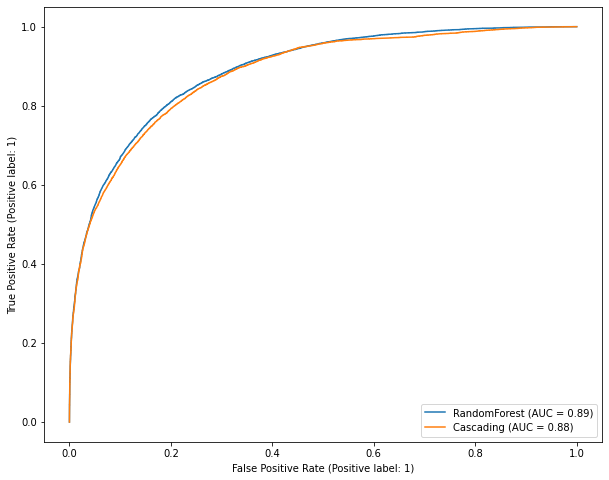

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

RocCurveDisplay.from_predictions(Y_test, rf_calib.predict_proba(X_test)[:,1], ax=ax, name="RandomForest")
RocCurveDisplay.from_predictions(Y_test, probas, ax=ax, name="Cascading")

Efectivamente, ambas curvas son muy similares, pero la de Cascading tiene menos área, por lo tanto el score es menor. Esto probablemente indica una leve variación en las predicciones de algunas instancias, de modo que para ciertos umbrales la predicción es peor.

## Preprocessing Nº 2

In [13]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

### RandomForestClassifier y Red neuronal

Como pudimos comprobar, la utilización de modelos sencillos para la primera capa de cascading, si bien en teoría es una buena idea, en este caso los scores empeoraron. Por lo tanto, probamos la combinación de dos de los mejores modelos que obtuvimos a lo largo del TP: una red neuronal y un random forest. En el caso de la red, no utilizamos la que dio los mejores resultados, ya que se trataba de un modelo bastante complejo. En su lugar, utilizamos otra que también dio muy buenos resultados.

In [14]:
# Copio la funcion de NeuralNetwork.ipynb porque
# se precisa para cargar el modelo
def get_model(cant1, cant2, act1, act2, reg):
    model = Sequential()
    model.add(Dense(cant1, input_shape = (len(X_train[0]),), activation=act1, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(cant2, input_shape = (len(X_train[0]),), activation=act2, kernel_regularizer=l2(reg)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adadelta(learning_rate = 1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
    return model

grid = load('NeuralNetwork/grid.joblib') 

2021-12-08 19:46:15.036342: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-08 19:46:15.036385: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (elian): /proc/driver/nvidia/version does not exist
2021-12-08 19:46:15.036795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
neural_network = grid.best_estimator_
# Probamos usar RandomForest como primer modelo pero
# los resultados empeoraban
models = [
    ("NeuralNetwork", neural_network),
    ("RandomForest", RandomForestClassifier(criterion="entropy", max_depth=35, n_estimators=200, random_state=0))
]

In [16]:
cascading_ = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1])

In [17]:
cascading_.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 41093 instancias, 25426 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 10167 instancias, 15259 no lograron ser clasificadas


In [18]:
probas = cascading_.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 21890 instancias, 13929 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 477 instancias, 13452 no lograron ser clasificadas


In [19]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894347,0.860716,0.767479,0.542088,0.635387


### Aumentando el threshold

Si aumentamos el threshold, el segundo modelo recibirá más instancias, tanto en `fit()` como en `predict_proba()`. Esto puede ser bueno, porque reduciría las probabilidades de que el segundo modelo overfitee. Por otro lado, si lo aumentamos mucho, el primer modelo no podrá predecir correctamente ninguna instancia, por lo que el segundo modelo recibiría todas las instancias, haciendo que el cascading pierda sentido.

In [20]:
cascading = CascadingClassifier(models=models, threshold=0.9, idx_to_use_calib=[1])

In [21]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 35250 instancias, 31269 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 5127 instancias, 26142 no lograron ser clasificadas


In [22]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 18734 instancias, 17085 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 142 instancias, 16943 no lograron ser clasificadas


In [23]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.895179,0.8608,0.768265,0.541589,0.635313


Los modelos clasificaron correctamente menos instancias, como era esperado. Los scores se mantuvieron relativamente similares. Esto podría significar que a ambos modelos les resulta difícil clasificar el mismo set de instancias.

Podemos agregar más modelos y ver si logran clasificar correctamente más instancias.

### Agregando SVC

Usamos la combinación de hiperparámetros que produjo los mejores resultados en SVC

In [24]:
if len(models) == 2:
    models.append(
        ("SVC", SVC(kernel = 'poly', random_state = 0, max_iter=100000, C = 1, degree = 3, coef0 = 1, gamma = 0.01, probability=True))
    )

In [25]:
cascading = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1])

In [26]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 41963 instancias, 24556 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 9430 instancias, 15126 no lograron ser clasificadas
Modelo: SVC logro clasificar 4 instancias, 15122 no lograron ser clasificadas


In [27]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 22465 instancias, 13354 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 332 instancias, 13022 no lograron ser clasificadas
Modelo: SVC logro clasificar 6 instancias, 13016 no lograron ser clasificadas


In [28]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894814,0.863397,0.782334,0.540092,0.639026


Lamentablemente, SVC no pudo clasificar una cantidad significativa de instancias, por lo que el score se mantuvo prácticamente igual.

### Agregando KNN

In [29]:
if len(models) == 3:
    models.pop()
models.append(
    ("KNN", KNeighborsClassifier(n_neighbors = 55, weights = "distance"))
)

In [30]:
cascading = CascadingClassifier(models=models, threshold=0.85, idx_to_use_calib=[1, 2])

In [31]:
cascading.fit(X_train, Y_train)

Modelo: NeuralNetwork logro clasificar 42786 instancias, 23733 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 8622 instancias, 15111 no lograron ser clasificadas
Modelo: KNN logro clasificar 0 instancias, 15111 no lograron ser clasificadas


In [32]:
probas = cascading.predict_proba(X_test)

Modelo: NeuralNetwork logro clasificar 22914 instancias, 12905 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 217 instancias, 12688 no lograron ser clasificadas
Modelo: KNN logro clasificar 0 instancias, 12688 no lograron ser clasificadas


In [33]:
metrics_table(Y_test, probas > 0.5, probas)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.894715,0.86295,0.77252,0.549694,0.642332


El nuevo modelo no alcanzó el threshold en ninguna instancia. Sin embargo, el score aumento ligeramente. Esto quiere decir que mejoró la predicción de alguna instancia, a pesar de que la certeza no fue mayor a 0.85.

Como conclusión, podemos ver que es difícil mejorar los scores utilizando cascading, principalmente por dos motivos:
- Si se utilizan dos modelos de complejidad similar (ej: árbol de decisión y Naive Bayes), las instancias predichas con poca certeza por un modelo, serán predichas con poca certeza por el otro.
- Si se utiliza un modelo simple y luego un modelo complejo (ej: árbol de decisión y Random Forest), las instancias predichas con buena certeza por el primer modelo, podrían ser predichas con más certeza por el segundo. Pero como se supera el threshold, dichas instancias quedarán con las probabilidades del primer modelo. Bajo la métrica ROC AUC, esto implica un peor score.

Finalmente, nos quedamos con el modelo que utilizó una red neuronal y random forest (*threshold* = $0.85$) ya que, si bien el score fue un poco menor al último modelo, es más simple (el último modelo agrega KNN, es decir, un estimador base más).

## Predicción de nuevos datos

In [34]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
df_extra = hashing_trick(df_extra, 24, "barrio")

model = cascading_

pipe.steps.append(("casc", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict_proba(df_extra) > 0.5})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {False: "no", True: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/CascadingClassifier.csv")

Modelo: NeuralNetwork logro clasificar 18724 instancias, 10368 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 252 instancias, 10116 no lograron ser clasificadas


## Predicción en Holdout

In [35]:
df_features_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
df_target_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(df_features_holdout, df_target_holdout)
viento_trigonometrico(df_features_holdout)
df_features_holdout = hashing_trick(df_features_holdout, 24, "barrio")

In [40]:
probas = pipe.predict_proba(df_features_holdout)
metrics_table(df_target_holdout, probas > 0.5, probas)

Modelo: NeuralNetwork logro clasificar 7334 instancias, 4052 no lograron ser clasificadas
Modelo: RandomForest logro clasificar 88 instancias, 3964 no lograron ser clasificadas


,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.89513,0.858686,0.771077,0.519527,0.620787


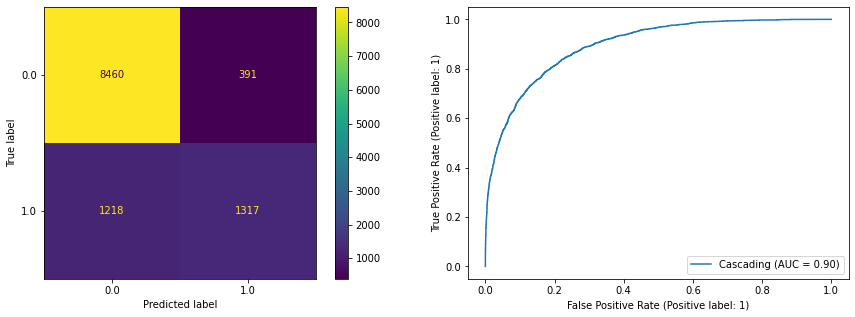

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

ConfusionMatrixDisplay.from_predictions(df_target_holdout, probas > 0.5, ax=axs[0])
RocCurveDisplay.from_predictions(df_target_holdout, probas, ax=axs[1], name="Cascading")
plt.show()

Los resultados son interesantes. AUC-ROC y Precision aumentaron ligeramente con respecto al set de test, mientras que las otras métricas disminuyeron bastante. El único caso en que se había observado una situación similar, es en el random forest que, curiosamente, es uno de los estimadores utilizados en el cascading final. Recall y F1 Score fueron las métricas más afectadas.